<a href="https://colab.research.google.com/github/AnaNava1996/Proyecto_Bedu/blob/main/Entrega_Final_MachineLearning_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/Proyecto_Equipo10_Incendios_Forestales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de Incendios Forestales**
### Proyecto BEDU Data Science, Modulo Final
* Eréndira Celis Acosta
* Ana Paola Nava Vivas
* Hegar José García Rodríguez
* Gerardo Leonel García Pegueros

# Introducción

En módulos anteriores pudimos familiarizarnos con distintos datasets asociados a los incendios forestales en México. Así como también entender mejor este fenómeno por medio del análisis con diversas técnicas.

El objetivo de este proyecto es aplicar modelos de series de tiempo y clasificación con Pandas para crear predicciones sobre los incendios.

Para esto se utilizarán bases de datos de incendios por ecorregión y uso de suelo en México proporcionadas por la Comisión Nacional para el Conocimiento y Uso de la Biodiversidad, así como también puntos geográficos de calor obtenidos del Sistema de Información de Incendios para Manejo de Recursos de la NASA.

En este módulo utilizamos algoritmos de machine learning como una nueva aproximación para predecir (SARIMA y LSTM) y clasificar (DBSCAN) los incendios forestales, ya que esto puede aportar a un mejor monitoreo y por tanto prevención de los mismos.

# Instalaciones

In [ ]:
#! pip install geopandas rtree
#! apt install libspatialindex-dev
! pip install --upgrade plotly
! pip install tensorflow
! pip install keras_metrics

     |████████████████████████████████| 19.1MB 1.8MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


# Clusterización

### Contexto

En los módulos previos, se realizaron análisis en base a la clasificación de los puntos de calor en eco-regiones definidas en relación a su ubicación. Se quizo hacer uso de las herramientas de clustering para indagar en formas más convenientes de monitorear y predecir incendios. 

Hacemos este procesamiento bajo el supuesto que las ecorregiones en México son muy vastas, por lo que no son convenientes para dividir el territorio nacional en zonas estratégicas que permitan el control y prevención de incendios in-situ. 

La forma inicial se planteó el uso de K-Means para clusterizar los puntos de calor, generados por los incendios, sin embargo después de un proceso de investigación y pruebas llegamos a la conclusión que dicho algorítmo no iba a cumplir con nuestras necesidades, desde un punto de vista técnico, por limitaciones de la librería, y análitico dado que en base a un [estudio](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/), se encuentró que el uso de sistemas de coordenadas basados en geodécicas puede generar distorciones significtivas en los datos en zonas lejanas al ecuador, zonas de alta presencia en nuestro dataset.

Por lo anterior, se optó por utilizar el algoritmo de DBSCAN, el cual nos proveé un balance entre la funcionalidad y precisión requerida para la correcta ejecución del proyecto, a continuación se va a describir el algoritmo.

### Importación de bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

### Importación de datos

Descargamos el dataset de la plataforma de identifación de incendios de la NASA (puntos de calor), en el periodo 2000 a 2020.

In [ ]:
def fetch_fire_dataset(year):
  base_url = "https://firms.modaps.eosdis.nasa.gov/data/country/modis"
  current_url = f"{base_url}/{year}/modis_{year}_Mexico.csv"
  return pd.read_csv(current_url)

fire_data = pd.concat(list(map(fetch_fire_dataset, range(2000,2020))), axis=0)

### Preprocesamiento de datos

Filtramos los datos para trabajar sólo con los que están asociados a incendios forestales y tienen una confianza alta (mayor al 90%)

In [ ]:
filtro_alta_confianza = fire_data['confidence'] > 90
filtro_incendios = fire_data['type'] == 0
fire_data = fire_data[filtro_alta_confianza & filtro_incendios][['longitude','latitude']]

Verificamos la cantidad de datos que tenemos y los visualizamos de forma muy general.

In [ ]:
fire_data.shape

(126941, 2)

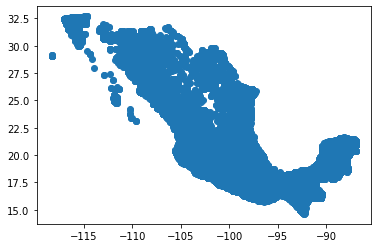

In [ ]:
plt.scatter(fire_data['longitude'],fire_data['latitude'])
plt.show()

Ahora almacenamos nuestros datos en un formato adecuado para ingresarlos al algoritmo de DBSCAN.

In [ ]:
X = fire_data[['latitude','longitude']].values

### Procesamiento de datos

DBSCAN es un algoritmo de clustering basado en la densidad, que forma clusters de regiones densas en puntos y descarta las zonas de baja densidad (Las considera outliers o ruido).

 Este algoritmo utiliza dos parámetros definidos por el usuario:

*   Epsilon (`eps`): se define como la máxima distancia entre dos puntos para ser considerados como vecinos, es decir, que pertenecen al mismo cluster.
*   Puntos mínimos (`min_samples` o `minPts`): Esto define la cantidad mínima de puntos vecinos que un punto dado necesita tener para ser considerado como del **núcleo** del cluster. 

El [algoritmo de DBSCAN](https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27) es sensible al valor de epsilon que elijamos, debido a ello, existe el "Método de la rodilla" cuyo objetivo es encontrar la media de distancias para cada punto con sus K vecinos más cercanos y seleccionar la distancia a la cual ocurre una inflexión significativa (ver gráfico siguiente). El valor de K se establece como igual a `min_samples` (50 en el caso de la iteración final seleccionada para DBSCAN como puede verse más adelante).

Sin embargo, el valor obtenido (0.07) resulta ser demasiado pequeño si se interpreta directamente... y demasiado grande si se considera que son radianes y se hace la conversión inversa/equivalente a la que se realiza en DBSCAN, por lo que al final no se utilizó este valor.

In [ ]:
nearest_neighbors = NearestNeighbors(n_neighbors=50)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)[:, 1]

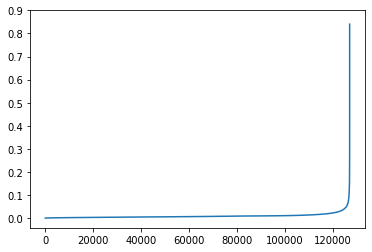

In [ ]:
plt.plot(distances)
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

Se inicializan los parámetros del algoritmo, el divisor que se ve en epsilon (6371) es la conversión a radianes necesaria para que el algoritmo trabaje con distancias geodésicas (semiverseno) que en los parámetros se maneja como `metric='haversine'`. 

In [ ]:
fire_dbscan = DBSCAN(eps=20/6371, min_samples=50,algorithm='ball_tree', metric='haversine')

El siguiente paso es la aplicación del algoritmo a los datos (que también deben pasarse a radianes).

In [ ]:
fire_dbscan.fit(np.radians(X))

DBSCAN(algorithm='ball_tree', eps=0.0031392246115209545, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=50, n_jobs=None,
       p=None)

Los siguientes pasos implican un reacomodo de los datos clusterizados para evaluar el proceso y visualizarlos.

In [ ]:
labels = fire_dbscan.labels_

Las label `-1` significan que son un punto outlier.

El resto de valores, como número enteros, son etiquetas de los clústers

In [ ]:
labels

array([ 0, -1,  0, ..., 18,  2,  0])

In [ ]:
len(labels[labels == -1])

4885

In [ ]:
# Creamos un arreglo de numpy con todos los valores en falso por default.
core_samples_mask = np.zeros_like(labels, dtype=bool)

In [ ]:
# Establecemos puntos núcleo y de frontera (todos los que no son -1) a True.
core_samples_mask[fire_dbscan.core_sample_indices_] = True

### Análisis de resultados

Para evaluar los resultados del clustering es útil saber el número de clusters generados y la proporción de puntos considerados como ruido (outliers).

In [ ]:
# Acumulamos y encontramos el número de clusters (separándolos del ruido o outliers)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
percentage_noise_ = n_noise_ / X.shape[0] * 100

print('Número estimado de clusters: %d' % n_clusters_)
print('Número estimado de puntos de ruido: %d' % n_noise_)
print('Porcentaje estimado de puntos de ruido: %d' % percentage_noise_)

Número estimado de clusters: 45
Número estimado de puntos de ruido: 4885
Porcentaje estimado de puntos de ruido: 3


Para estos parámetros, tenemos una cantidad de clusters mayor al número de ecorregiones, agrupación contra la que se está comparando, pero tampoco son demasiados y son pocos puntos los que quedaron sin clúster (outliers o ruido). 

También aplicamos el [coeficiente de la silueta](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) para evaluar la calidad de los clusters de forma más objetiva. Este coeficiente tiene valores en el rango de (-1,1) donde 1 significa que los clusters están bien definidos y separados uno de otro y en -1 es todo lo contrario.

In [ ]:
# Esta celda toma aproximadamente 4.5 minutos en ejecutarse
s = metrics.silhouette_score(X, fire_dbscan.labels_)
print(f'Coeficiente de silueta para clusters de incendios: {s:.2f}')

Coeficiente de silueta para clusters de incendios: -0.08


El resultado es muy cercano a cero por lo que es un resultado neutro de cierta forma. Es importante mencionar que estos parámetros, `eps=20` y `min_samples=50`, son los que nos dieron mejores resultados después de 15 iteraciones de prueba con distintos valores para los parámetros de entrada. 

Por **mejor resultado** damos a entender que se generó una cantidad adecuada de clusters, ni se redujo tanto la distancia epsilon, al tiempo que el coeficiente de silueta fue el mayor posible.

### Interpretación de resultados

Ahora vamos a evaluar visualmente el resultado del proceso:

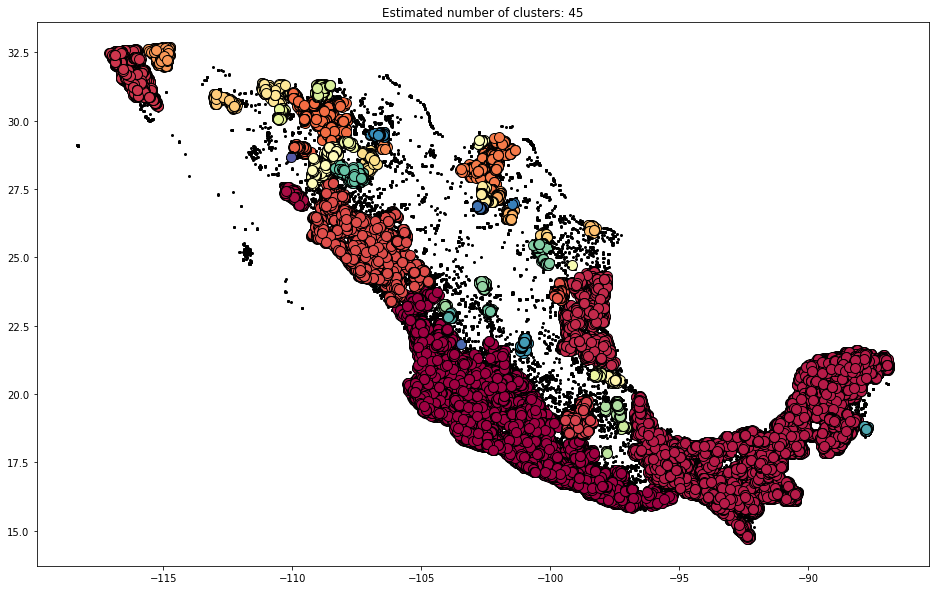

In [ ]:
unique_labels = set(labels)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(10)

colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
cols = ['longitude','latitude','cluster_label']
df_ = pd.DataFrame(columns=cols)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Color negro para denotar ruido
        col = 'k'
    
    class_member_mask = (labels == k)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col, markeredgecolor='k', markersize=2)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
    
    mmm = (xy.shape[0])*[k]
    aux_df = pd.DataFrame(list(zip(xy[:, 1], xy[:, 0], mmm)), columns=cols)
    df_ = pd.concat([df_, aux_df])
  
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Podemos ver un gran desbalance en el tamaño de los clusters en relación sur - norte donde los primeros son muy grandes y extensos y los segundos son muy pequeños y localizados. 

Si recordamos la geometría de las ecorregiones, podemos ver que los tres clusters más extensos se parecen a las tres ecorregiones con la mayor cantidad de incendios: selvas (húmedas y secas) y sierras templadas. 

También es interesante ver el cluster más al noroeste del país, que coincide claramente con la ecorregión de California Mediterránea, en los módulos anteriores, dicha que aunque no tiene la mayor cantidad de incendios en términos absolutos, sí presenta una de las mayores densidades espaciales de incendios. 

Cabe señalar que con distintas iteraciones para valores de epsilon muy bajos (menores a 10) y distintos valores de `min_samples`, estos tres grandes clusters no cambiaron significativamente y por el contrario se afectaban a los clusters más pequeños del norte del país, aumentando los puntos de ruido y afectando el coeficiente de silueta. 

Lo anterior demuestra la alta y constante densidad de puntos de incendios en las ecorregiones del sur y sureste del país que se ve reflejada aún en datos no-etiquetados.

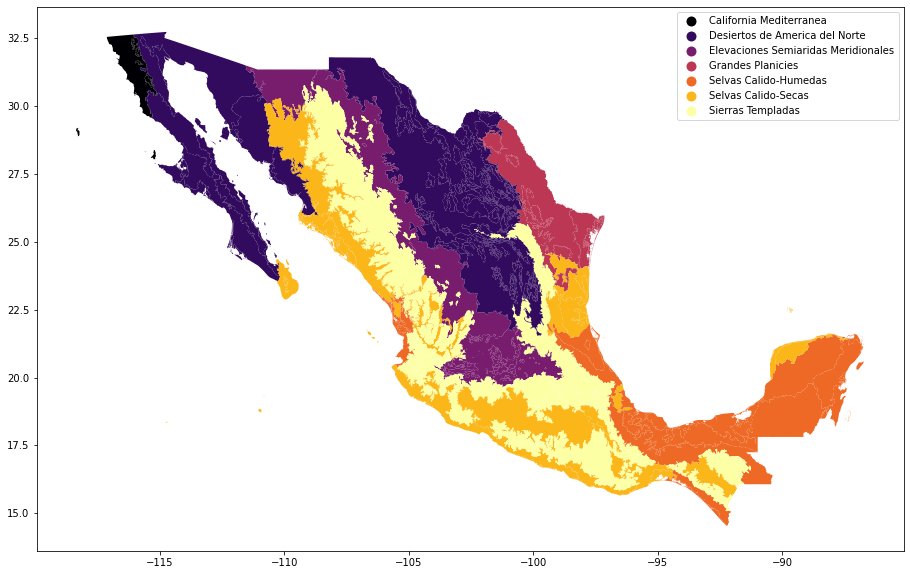

### Exportación de datos

Aquí simplemente corroboramos el tamaño final de los datos clusterizados, son un poco menos que los iniciales, dado que se cuenta con un 3% de ruido.

In [ ]:
print(len(labels))
print(X.shape)
print(df_.shape)

126941
(126941, 2)
(116309, 3)


Softwares especializados como QGIS, nos permiten generar mejores visualizaciones de los datos generados y obtener una mejor separación visual de los clústers; sin embargo los equipos que se tienen a la mano no cuentan con los recursos necesarios para realizar las proyecciones.

> Los datos requeridos para su uso en otros softwares es en base a CSV.

In [ ]:
df_.to_csv('dbscan_clustered_labeled_fire_data.csv')

# Predicción de tiempo.

## Contexto

En análsis anteriores, se encontró la existencia de cierta relación entre la fecha del año y la cantidad de incendios por ecorregión.

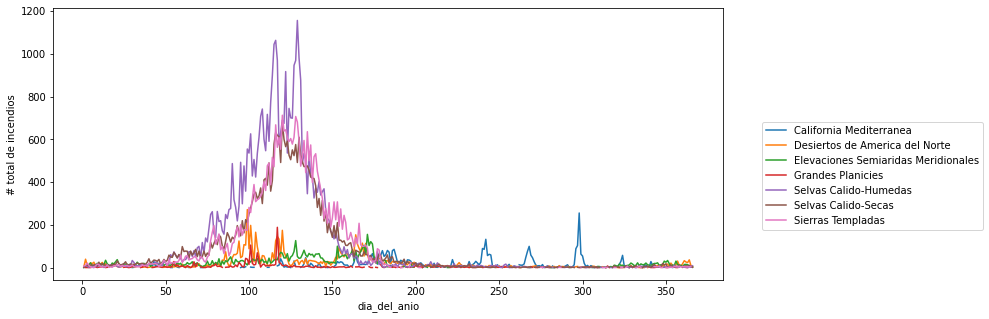

En el caso de las ecorregiones de nivel 1, se obtó por hacer uso de un subset de los datos correspondientes a las Selvas Cálido Húmedas dado a que cuentan con la mayor cantidad de incendios.

Usando un Scatterplot, se observó que no había correlación de Pearson entre el día del año y el número de incendios. Sin embargo, se corroboró que que año tras año, se formaba una concentración de incendios en ciertos días del año, correspondientes a las temporadas de sequía.

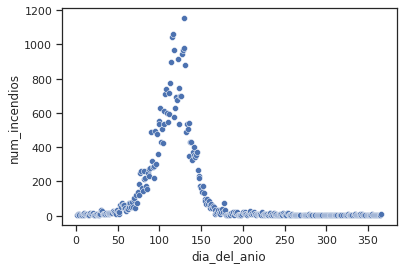

### Regresión Lineal

Inicialmente se planteó el uso de regresiones líneales para el análisis de la tendencia de cantidad de incendios en relación con el día del año, como se ve a continuación donde se acotó del día 1 al 125 del año, sin embargo rápidamente observamos que la aproximación con regresión lineal no era un buen análisis y se decidió hacer uso de otros métodos.


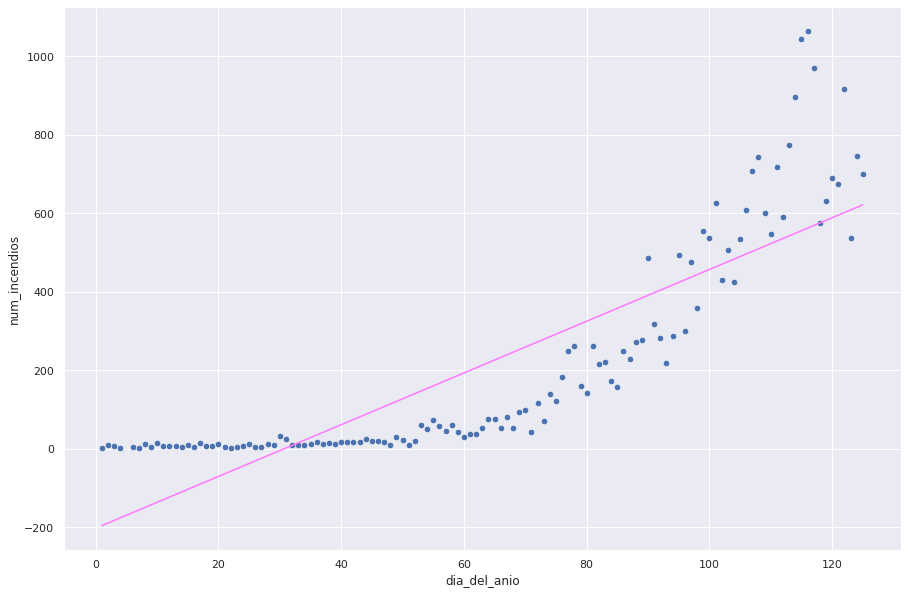

### Predicción con SARIMA, "Seasonality-Autorgresive-Integrated-Moving Average"

Durante nuestra investigación encontramos el algoritmo Sarima, el cual está basado en ARIMA agregando un factor de "Seasonality", el cual se adapta al caso de estudio dado el patrón temporal que se tiene, años.

Sin embargo, tras ciertas pruebas concluímos que su forma de trabajo genera predicciones en un patrón cíclico, por lo que se generaban *Falsos Verdaderos* en épocas del año donde no corresponde, al igual que agregando un retraso a la predicción.

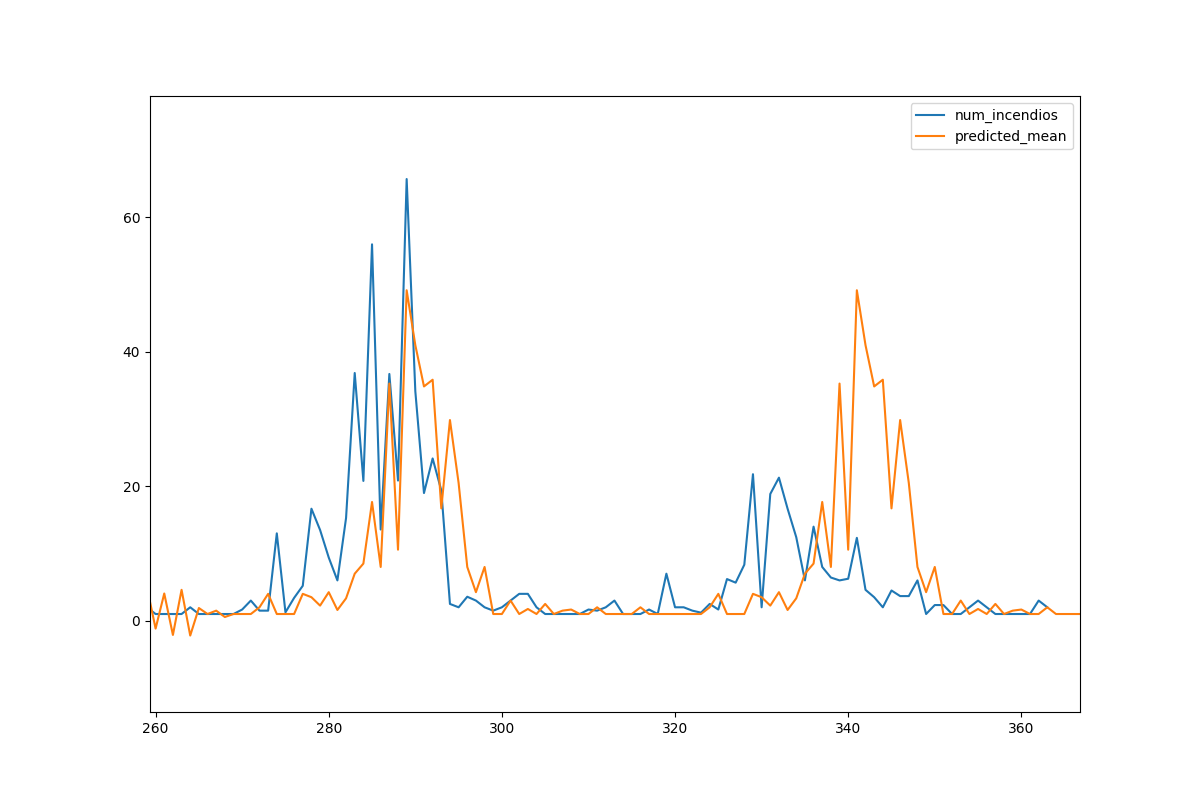

Para revisar el código de SARIMA, [dar click aquí.](https://github.com/AnaNava1996/Proyecto_Bedu/blob/main/Entrega_Final_MachineLearning_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/otros_programas/sarima.py)

SARIMA no dió los resultados que esperábamos, ya que si bien nuestro data set cumplía con un patrón que se repetía año tras año, eran demasiados datos por tratarse de fechas individuales; realizar el análsis con base en meses posiblemente nos hubiera permitido mejorar el nivel de certeza pero esto no nos iba a proveer la precisión que buscábamos para conocer el número de incendios en un día específico.


## Predicción utilizando LSTM 🎉

Se consideró el uso de Deep Learning, derivado del concepto visto en clase que un red puede equivaler a una regresión logística.

Dentro de las opciones de Deep Learning se encontraba **Recurrent Neural Networks** (RNN), pero es una red que presenta un problema de "vanishing gradient" ya que en cada "back propagation" disminuyen las gradientes y por lo tanto los pesos y bias dejan de actualizarse, es decir, el algoritmo deja de aprender.

**Long Short Term Memory (LSTM)**, funciona de forma similar a *RNN*, sin el problema del gradiente, además de tener buen grado de aprendizaje con datasets largos como el nuestro.

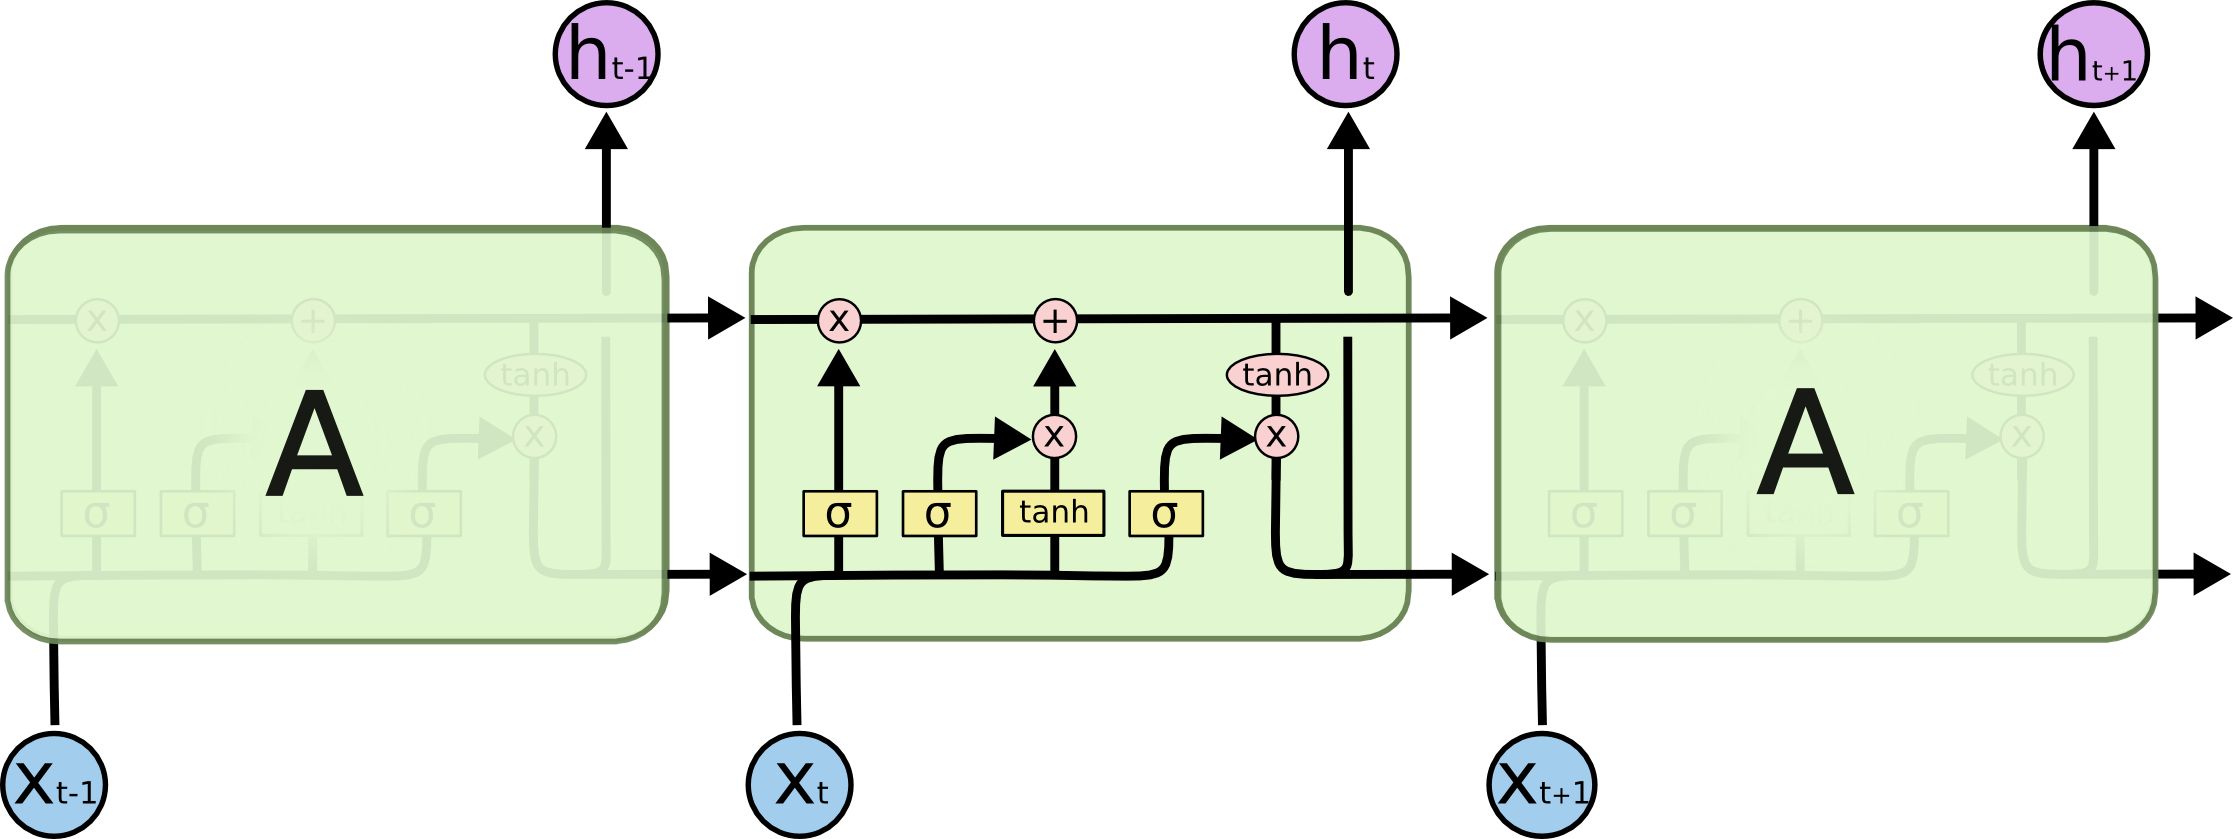

### Librerías y preparación de los datos para entrenar el modelo.

In [38]:
#correr previamente la celda de los import.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras_metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Vamos a crear una función para retornar dos arreglos de numpy basados en el set de datos que ya tenemos. El parámetro de look_back tendrá por defecto el valor de 30 que corresponde a aproximadamente un mes.

In [ ]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])# 30 fechas - De fila de 0 a 29
        dataY.append(dataset[i + look_back, 0])# tomo la fecha 30... y asi sucesivamente...
    
    return np.array(dataX), np.array(dataY)


In [ ]:
# Función que le añade las fechas restantes en ceros. USO: df = makeDate(df)
def makeDate(df):
    df.fecha = pd.to_datetime(df.fecha)
    df.set_index(['fecha'],inplace=True)
    idx = pd.date_range(min(df.index), max(df.index))
    df = df.reindex(idx,fill_value=0)
    return df

Vamos a abrir el data set de incendios en las ecorregiones de tipo 1 por fechas, que obtuvimos en módulos anteriores. En este caso vamos a filtrar y predecir las Selvas Cálido Húmedas.

In [37]:
columna = 'ecorregion_nivel_1'

df = pd.read_csv("https://raw.githubusercontent.com/AnaNava1996/Proyecto_Bedu/main/Entrega_Final_MachineLearning_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/datasets/incendios_x_fecha_x_ecorregion.csv",parse_dates=True)[['fecha','num_incendios',columna]]
df = df.loc[df[columna] == "Selvas Calido-Humedas"]
del df[columna]
df = makeDate(df)

np.random.seed(100)

df.head(5)

,num_incendios
2000-11-29,1
2000-11-30,0
2000-12-01,0
2000-12-02,0
2000-12-03,0


Convierto los datos a tipo float.

In [ ]:
dataset = df.values
dataset = dataset.astype('float32') # Convierto el numero de incendios a float

Normalizo a una escala de mínimo 0 y máximo 1. Esto se hace para que los datos puedan pasar por las funciones de activación.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Particiono los datos en set de entrenamiento y set de prueba para comparar la predicción con el valor real en la fecha.

In [ ]:
train_size = int(len(dataset) * 0.7) # Tamaño del entrenamiento
test_size = len(dataset) - train_size # Tamaño de la prueba
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Formateo un poco los datos para poderlos introducir al modelo.

In [ ]:
# Convertir los datos de entrenamiento a arreglos de numpy
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# Reshape de los datos para prepararlos para la red neuoronal
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Topología de la red neuronal.

La topología de la red neuronal que utilizaremos se ve en la siguiente imagen.

lstm.png

Procedemos a crear un modelo **LSTM**, usando la función `Sequential` que forma parte de Keras, dado que los datos pueden verse como secuencia temporal.

Se tendrán 2 capas de 256 neuronas, la primera recibirá un vector del tamaño del lookback. En el `Dropout` se tiene un valor que es la probabilidad de que no se deje pasar el resultado de la función: $$h(t)$$ a la siguiente capa, permitiendo controlar el overfitting.

La segunda capa recibirá los valores resultantes de la primera capa.


In [ ]:
# Crear el modelo LSTM
model = Sequential()

# Primera capa de 256 entradas
# Agrego una capa de 256 neuronas...
model.add(LSTM(256, input_shape=(1, look_back),return_sequences=True)) 

# Evita overfiting
model.add(Dropout(0.9)) 

#Segunda capa de 256 entradas
model.add(LSTM(256, input_shape=(1, int(look_back/3))))


Finalmente, los resultados de la segunda capa pasan a la capa Densa, que es una sola neurona con función de activación **SELU**, la cual va a entregar el resultado final de una sola predicción a la vez.

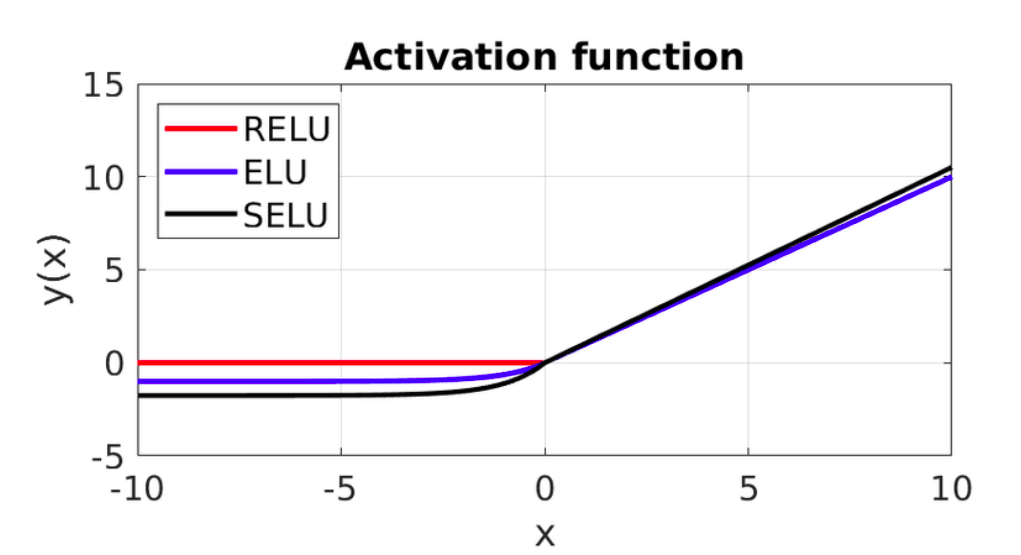

In [ ]:
# Capa densa, la capa que recibe todo.
model.add(Dense(1))

# Función de activación
model.add(Activation('selu'))

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy','mae',keras_metrics.recall()])

### Entrenamiento de la red neuronal.

Se entrena el modelo "epochs" veces, con la lista de arreglos de numpy, TrainX, y la lista de resultados TrainY.

In [ ]:
# Se entrena la red neuronal con el dataset "epochs" veces.
model.fit(trainX, trainY, epochs=15, batch_size=15, verbose=0)

# Resultado de las predicciones sobre los datos de entrenamiento y los datos de prueba
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


### Cálculo del Error y evaluación de nuestra red. 

Desnormalizamos los datos que anteriormente habían pasado a una escala de 0 a 1.

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Calculamos el Root Median Square Error.

 $$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 13.1162 RMSE
Test Score: 10.2010 RMSE


Teniendo en cuenta que el rango del dataset va de 0 incendios a 222 incendios registrados en un solo día (el pico más alto). Consideramos que un error de 11.0396/222 en el Test Score, es decir 0.049 es bueno.

**Por lo que nuestro modelo tiene una exactitud de 95.1% 🎉🎉🎉**

Como aclaración, este valor RMSE, puede variar ligeramente debido al resultado random de la semilla.

### Gráfica de la predicción.

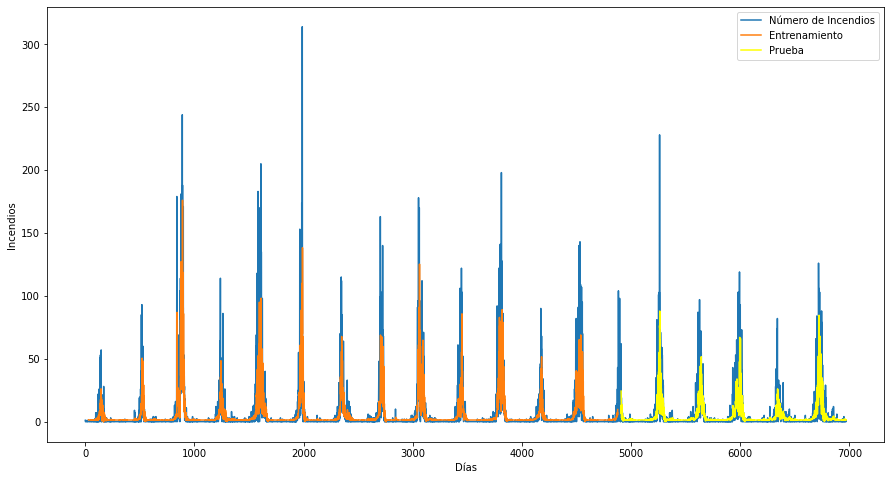

In [ ]:
# Desplazamiento de datos para graficación
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Desplazamiento de datos para graficación
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dataset),label='Número de Incendios')
plt.plot(trainPredictPlot,label='Entrenamiento')
plt.plot(testPredictPlot,color='yellow',label='Prueba')
plt.xlabel('Días')
plt.ylabel('Incendios')
plt.legend()
plt.show()

Cabe aclarar que estos resultados en la prueba se obtienen utilizando 30 valores del dataset real para predecir el valor siguiente. Si se quisiera predecir un año completo habría que utlizar los valores arrojados por la LSTM como si fueran los reales para predecir los siguientes.

# Conclusiones

SARIMA no se ajustó a nuestras necesidades dado el alto volumen de datos. Evidentemente existe un patrón que se repite año tras año, y con Sarima habría sido mejor medir con base en meses, no obstante eso no nos brinda la precisión que buscábamos para conocer el número de incendios en un día específico.

Para nuestra serie de tiempo, el algoritmo que mejor se adaptó fue **LSTM**. Además no tuvimos que especificar una ventana de tiempo donde se encontrara el patrón, ya que LSTM está equipado para aprender correlaciones a largo plazo en una secuencia, por lo que pueden modelar secuencias complejas multivariadas sin la necesidad de especificar ninguna ventana de tiempo.

Con nuestros resultados de la red neuronal podemos predecir con una certeza de 95.1% el número de incendios en una ecorregión determinada, eso sí utilizando cada día los datos actualizados de la NASA para reentrenar el modelo y predecir el día siguiente.

Este resultado es importante porque nos permite predecir el pico de incendios en una ecorregión en 1 año determinado y así poder desplegar esfuerzos oportunamente. De igual forma buscar adaptar algoritmos que apoyen a la predicción de la posible área de afectación.

Respecto a la clusterización de los puntos de calor, se pudo corroborar que las ecorregiones son una buena aproximación regional para el monitoreo de incendios forestales pero si se quiere hacer una clasificación que priorice una homogeneidad en el tamaño espacial de los clusters, DBSCAN no es lo más adecuado ya que prioriza la densidad, la cual varía de forma muy extrema del sur al norte del país en el caso de los incendios.

Aunque quedó fuera del alcance de este trabajo, sería interesante hacer un proceso de clustering por separado con las ecorregiones de alta y baja densidad de incendios respectivamente para analizar la distribución de los puntos de calor y evaluar, por ejemplo, si los clusters más locales coinciden con zonas urbanas, agrícolas o actividad humana en general. 

# Referencias

[1] https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27|

[2] https://colah.github.io/posts/2015-08-Understanding-LSTMs/

[3] https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

[4] https://stats.stackexchange.com/questions/56302/what-are-good-rmse-values

[5] https://www.quora.com/Why-is-the-number-of-neurons-in-a-neural-network-recommended-to-be-a-power-of-two#:~:text=It%20is%20just%20because%20of,be%20powers%20of%20two%2C%20too.